In [2]:
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.layers import Dense, LSTM
from keras.callbacks import  EarlyStopping
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import random
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD
import numpy as np
import os
import glob
import datetime
import pandas as pd
import yfinance as yf
from datetime import datetime 
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
import keras
import tensorflow as tf
%matplotlib inline

In [3]:
tickerSymbol= 'INTC' 

startDate = '1990-01-01' 
endDate = '2020-01-01' 

tickerData = yf.Ticker(tickerSymbol)

df = tickerData.history(period='1d', start=startDate, end= endDate)
new_cols= ['Open', 'High', 'Low', 'Volume', 'Close']
df= df[new_cols]

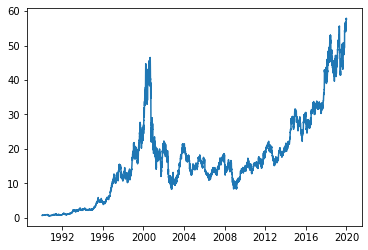

In [4]:
plt.plot(df['Close'])

#### Stationary Check:

In [ ]:
import math
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.graphics.tsaplots as tsaplots
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


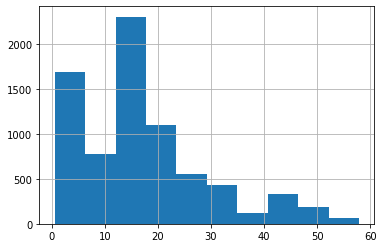

In [ ]:
df['Close'].hist()

In [ ]:
X = df['Close'].values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=10.826060, mean2=23.271254
variance1=94.052193, variance2=135.240472


In [ ]:
# Perform Dickey-Fuller test:
# Null Hypothesis (H_0): time series is not stationary
# Alternate Hypothesis (H_1): time series is stationary
print ('Results of Dickey-Fuller Test:')
result = adfuller(X)

dfoutput = pd.Series(result[0:2], index = ['Test Statistic','p-value'])
for key, value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic          0.154164
p-value                 0.969570
Critical Value (1%)    -3.431219
Critical Value (5%)    -2.861924
Critical Value (10%)   -2.566974
dtype: float64


In [ ]:
FUTURE_PERIOD_PREDICT=5

df1= df.copy()
df1['Close_shift'] = df1['Close'].shift(-FUTURE_PERIOD_PREDICT)
df1['Return1']= np.log(df1['Close_shift']/ df1['Close'])
df1['Return2']= df1['Return1']-1
df1['Return']= df1['Return1'].shift(-1) 

df1= df1.dropna(axis=0)
df1= df1[['Open','High', 'Low',	'Volume', 'Close', 'Return']]
df1.shape

(7553, 6)

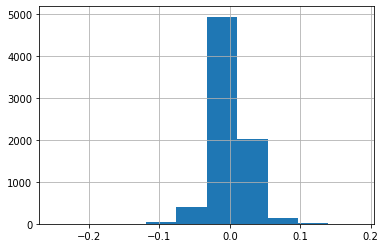

In [ ]:
df2['Return'].hist()

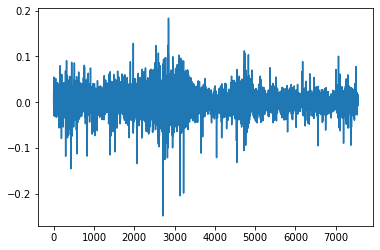

In [ ]:
df2= df1.reset_index(drop=True)
plt.plot(df2['Return'])

In [ ]:
X = df1['Return'].values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.004071, mean2=0.001802
variance1=0.003704, variance2=0.001448


In [ ]:
print ('Results of Dickey-Fuller Test:')
result = adfuller(df1['Return'])

dfoutput = pd.Series(result[0:2], index = ['Test Statistic','p-value'])
for key, value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic         -1.314439e+01
p-value                 1.408024e-24
Critical Value (1%)    -3.431220e+00
Critical Value (5%)    -2.861925e+00
Critical Value (10%)   -2.566975e+00
dtype: float64


#### Split train and test

In [5]:
def split_test_train(df1):
    test_percent = 0.10
    no_test_obs =  int(np.round(test_percent*len(df1)))
    training = df1[:-no_test_obs]
    testing = df1[-no_test_obs:]

    #spliting the testing data into validation and out of sample data:
    validation_percent = 0.70
    no_validation_obs = int(np.round(validation_percent*len(testing)))
    validation = testing[:-no_validation_obs]
    test = testing[-no_validation_obs:]
    #print(training.shape, validation.shape, test.shape)

    return training, validation, test

#### Scaling

In [6]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
def scale(training, validation, test, min_max_scaler):
    # transform scale
    min_max_scaler.fit(training.values)
    train_scaled = min_max_scaler.transform(training.values) 

    # applied training scale to validation and test set
    val_scaled = min_max_scaler.transform(validation.values)
    test_scaled = min_max_scaler.transform(test.values)

    return train_scaled, val_scaled, test_scaled

def split_xy(scaled_df):
    #training independent, dependent
    minmax_x,minmax_y = scaled_df[:,:-1],scaled_df[:,-1] 
    return minmax_x,minmax_y

In [8]:
def invert_scaling(x_minmax,y_predicted,n_steps_in):
    reshaped_pred = y_predicted.reshape((y_predicted.shape[0],1))
    matrix = concatenate((x_minmax[n_steps_in-1:],reshaped_pred), axis=1)
    matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
    inv_pred = matrix_min_max_invert[:,-1]
    return inv_pred

#### Split sequence

In [7]:
def split_sequences_new(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_indx = i + n_steps_in
        out_end_ix = end_indx + n_steps_out-1

        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_indx, :-1], sequences[end_indx-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
def plot_results(actual_y,predicted_y,method,date, length=10):
    mse = mean_squared_error(actual_y,predicted_y)
    
    plt.figure(figsize=(length,4))
    plt.plot(date,actual_y)
    plt.plot(date,predicted_y)
    plt.legend(['Actual','Predicted'])
    plt.title(f'{method} (MSE: {mse}, RMSE: {sqrt(mse)})')        
    plt.show()

In [11]:
def RSI(data, window=14, adjust=False):
    delta = data['Close'].diff(1).dropna()
    loss = delta.copy()
    gains = delta.copy()

    gains[gains<0] = 0
    loss[loss>0] = 0

    gain_ewm = gains.ewm(com=window-1, adjust=adjust).mean()
    loss_ewm = abs(loss.ewm(com=window-1, adjust=adjust).mean())

    RS = gain_ewm / loss_ewm
    RSI = 100 - 100/(1 + RS)
    
    return RSI

def get_wr(high, low, close, lookback):
    highh = high.rolling(lookback).max() 
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

In [10]:
def compute_r_squared(y_true, y_pred):
    #y_hat= model.predict(X)
    actual_y_mean = np.mean(y_true)

    score_1= y_true - y_pred
    score2= score_1**2
    residual= np.sum(score2)
    y_norm= y_true - actual_y_mean
    y_norm= np.sum(y_norm**2)
    r_squared= 1- (residual/y_norm)

    return r_squared

#### Model:

In [12]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #if epoch in [1, 81, 121, 161, 181]:
    #    print('Learning rate changed at epoch: {} is {}'.format(epoch, lr))
    return lr


def create_model(step_out, X_train, neurons, lr, epoch, optname):
    ################################################################# Reproducibility #########################################################
    tf.keras.backend.clear_session()
    np.random.seed(42)
    random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)
    #############################################################################################################################################

    np.random.seed(0)
    print(np.random.rand(4))

    #if optname=='SGD':
    #    opt= tf.keras.optimizers.RMSprop(learning_rate=lr, momentum=0.9)
    #elif optname=='RMSProp':
    #    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov= True)
    #elif optname=='ADAM':
    #lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr)
 
   ##################################################################################
    model = tf.keras.Sequential()
    model.add(LSTM(neurons[0], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation = 'tanh' , activity_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(BatchNormalization())
    model.add(LSTM(neurons[1],  return_sequences=True, activation = 'tanh', activity_regularizer=tf.keras.regularizers.L2(0.01)))  
    model.add(BatchNormalization())
    model.add(LSTM(neurons[2],  return_sequences=True, activation = 'tanh'))  
    model.add(BatchNormalization())
    model.add(LSTM(neurons[3],  return_sequences=False, activation = 'tanh'))  
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dense(64 ,activation = 'relu'))
    model.add(tf.keras.layers.Dense(32 ,activation = 'relu'))
    model.add(tf.keras.layers.Dense(step_out, activation = 'linear'))
    #####################################################################################
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', r_squared_metric])
    return model


def experiments_lstm(step_out, step_in, X_train, Y_train, X_val, Y_val, neurons_l, batch, epoch, decay_lr= True, lr=None, optname=None):

    #EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto',restore_best_weights=True)
    NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{(datetime.now())}"
    tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(NAME))
    filepath = "LSTM_Final-{epoch:02d}-{val_mse:.3f}" 
    #checkpoint = ModelCheckpoint("/content/drive/MyDrive/tensorboard_logs/model/{}.model".format(filepath, monitor='val_mse', verbose=1, save_best_only=True, mode='min'))
    if decay_lr:
 
        lr_scheduler = LearningRateScheduler(lr_schedule)
        lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),cooldown=0, patience=5,min_lr=0.5e-6)
        callbacks = [ lr_scheduler, lr_reducer, tensorboard]
        model= create_model(step_out, X_train, neurons_l, 0.0, epoch, optname)
        
        print('Using decay lr')
        # fit model
        history= model.fit(X_train, Y_train, epochs=epoch,batch_size= batch, verbose=0, validation_data =(X_val, Y_val) ,callbacks= callbacks)
    else:
        print('Using fixed lr: ', lr)
        callbacks = [tensorboard]
        model= create_model(step_out, X_train, neurons_l, lr, epoch)
        history= model.fit(X_train, Y_train, epochs=epoch,batch_size= batch, verbose=0, validation_data =(X_val, Y_val), callbacks= callbacks)
    
    return history, model
 

In [13]:
import keras.backend as K

def r_squared_metric(y_true, y_pred):
    actual_y_mean = K.mean(y_true)

    score_1= y_true - y_pred
    score2= score_1**2
    residual= K.sum(score2)
    y_norm= y_true - actual_y_mean
    y_norm= K.sum(y_norm**2)
    r_squared= 1- (residual/y_norm)

    return r_squared

### Weekly Return:

In [19]:
FUTURE_PERIOD_PREDICT=5
SEQ_LEN= 10
STEP_OUT=1 

In [20]:
df1= df.copy()
df1['Close_shift'] = df1['Close'].shift(-FUTURE_PERIOD_PREDICT)
df1['Return1']= df1['Close_shift']/ df1['Close']
df1['Return2']= df1['Return1']-1
df1['Return']= df1['Return2'].shift(-1) 

df1= df1.dropna(axis=0)
df1= df1[['Open','High', 'Low',	'Volume', 'Close', 'Return']]

df1['H-L'] = df1['High'] - df1['Low']
df1['O-C'] = df1['Close'] - df1['Open']
df1['3day_MA'] = df1['Close'].shift(1).rolling(window = 3).mean()
df1['10day_MA'] = df1['Close'].shift(1).rolling(window = 10).mean()
df1['30day_MA'] = df1['Close'].shift(1).rolling(window = 30).mean()
df1['Std_dev']= df1['Close'].rolling(5).std()
df1['RSI'] = RSI(df1) #talib.RSI(df1['Close'].values, timeperiod = 9)
df1['wr_14'] = get_wr(df1['High'], df1['Low'], df1['Close'], 14)
df1= df1.dropna(axis=0)
new_cols=['H-L','O-C','3day_MA','10day_MA','30day_MA',	'Std_dev','RSI','wr_14', 'Return']

df1=df1[new_cols]

In [21]:
train, validation, test= split_test_train(df1)
train_scaled, val_scaled, test_scaled= scale(train, validation, test, min_max_scaler)
trainMinmax_x, trainMinmax_y= split_xy(train_scaled)
valMinmax_x, valMinmax_y= split_xy(val_scaled)
testMinmax_x, testMinmax_y= split_xy(test_scaled)

X_train, Y_train = split_sequences_new(train_scaled, SEQ_LEN, STEP_OUT)
X_val, Y_val = split_sequences_new(val_scaled, SEQ_LEN, STEP_OUT)
X_test, Y_test = split_sequences_new(test_scaled, SEQ_LEN, STEP_OUT)

X_train.shape

(6762, 10, 8)

#### RF:

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
regr = RandomForestRegressor(max_depth=20, min_samples_split=20, random_state=0)
regr.fit(trainMinmax_x, trainMinmax_y)
rf_pred= regr.predict(testMinmax_x)
compute_r_squared(testMinmax_y, rf_pred)

-2.9130946740246584

In [23]:
matrix = concatenate((testMinmax_x,testMinmax_y.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
actual_yrf = matrix_min_max_invert[:,-1]


matrix = concatenate((testMinmax_x,rf_pred.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
inv_yrf = matrix_min_max_invert[:,-1]

In [24]:
print('RMSE: ', sqrt(mean_squared_error(inv_yrf, actual_yrf)))

RMSE:  0.08016033954671854


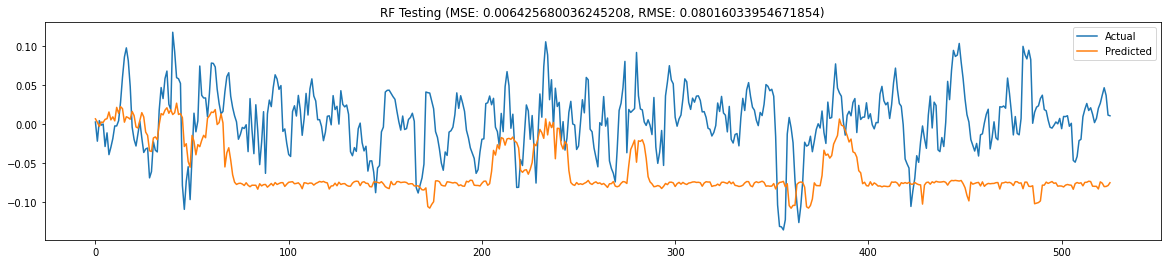

In [25]:
plot_results(actual_yrf,inv_yrf,'RF Testing',range(len(testMinmax_y)), 20)

#### LR

In [26]:
#Linear regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(trainMinmax_x, trainMinmax_y)


predictions = linreg.predict(testMinmax_x)
print(linreg.score(testMinmax_x, testMinmax_y))

-0.16396570137792033


In [27]:
matrix = concatenate((testMinmax_x,testMinmax_y.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
actual_ylr = matrix_min_max_invert[:,-1]


matrix = concatenate((testMinmax_x,predictions.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
inv_ylr = matrix_min_max_invert[:,-1]

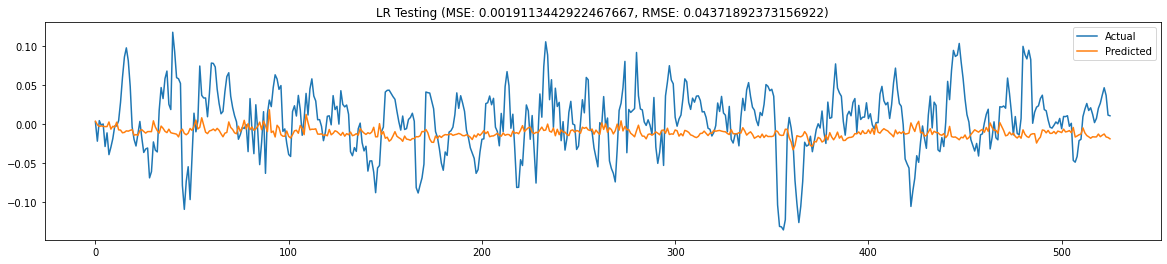

In [28]:
plot_results(actual_ylr,inv_ylr,'LR Testing',range(len(testMinmax_y)), 20)

#### LSTM 

In [33]:
neurons= [100, 100, 100, 100]
epochs=100
batch_size=64
decay_lr= True
lr= 0.01

historyw,modelw = experiments_lstm(STEP_OUT, SEQ_LEN, X_train, Y_train, X_val, Y_val, neurons, batch_size, epochs, decay_lr, lr)


[0.5488135  0.71518937 0.60276338 0.54488318]
Using decay lr


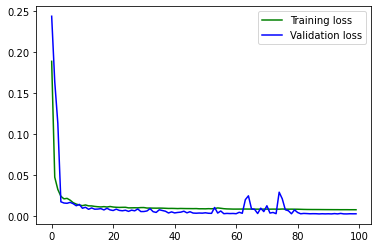

In [34]:
plt.plot(historyw.history['loss'],'g',label="Training loss")
plt.plot(historyw.history['val_loss'], 'b',label="Validation loss")
plt.legend()
plt.show()

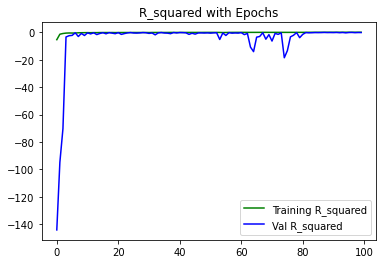

In [35]:
plt.plot(historyw.history['r_squared_metric'],'g',label="Training R_squared")
plt.plot(historyw.history['val_r_squared_metric'], 'b',label="Val R_squared")
plt.title('R_squared with Epochs')
plt.legend()
plt.show()

In [36]:
print('Train: ', modelw.evaluate(X_train, Y_train, verbose=0, batch_size=X_train.shape[0])[2])
print('Val: ', modelw.evaluate(X_val, Y_val, verbose=0, batch_size=X_val.shape[0])[2])
print('Test: ', modelw.evaluate(X_test, Y_test, verbose=0, batch_size=X_test.shape[0])[2])

Train:  0.107291579246521
Val:  -0.021378278732299805
Test:  -0.12579870223999023


In [37]:
# validation metrics 
lstmValPred = modelw.predict(X_val)
actual_valy= invert_scaling(valMinmax_x, Y_val, SEQ_LEN)
inv_valy= invert_scaling(valMinmax_x, lstmValPred, SEQ_LEN)

#out of sample metrics
lstmOutSamplePred = modelw.predict(X_test)
actual_y= invert_scaling(testMinmax_x, Y_test, SEQ_LEN)
inv_y= invert_scaling(testMinmax_x, lstmOutSamplePred, SEQ_LEN)

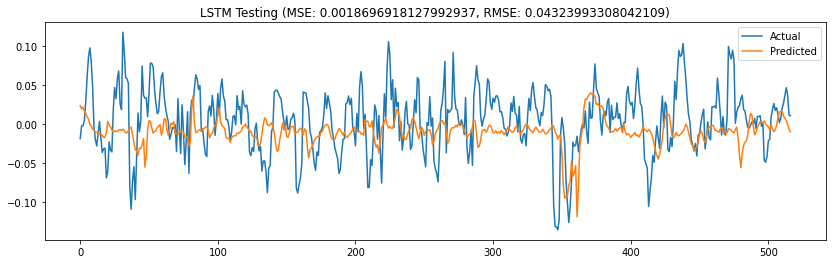

In [38]:
#plot_results(actual_valy ,inv_valy  ,'LSTM Validation',range(len(actual_valy)), 14)
plot_results(actual_y ,inv_y  ,'LSTM Testing',range(len(actual_y)), 14)

In [40]:
test_signal= 1*(actual_y>0)
pred_signal= 1*(inv_y>0)

right= sum(test_signal==pred_signal)
wrong= len(actual_y)-right

print('Right: ', right, 'Wrong: ', wrong)

Right:  245 Wrong:  272


### Monthly Return

In [39]:
FUTURE_PERIOD_PREDICT= 24
SEQ_LEN= 40
STEP_OUT=1 

##### Prepare data

In [41]:
df1= df.copy()

df1['Close_shift'] = df1['Close'].shift(-FUTURE_PERIOD_PREDICT)
df1['Return1']= df1['Close_shift']/ df1['Close']
df1['Return2']= df1['Return1']-1
df1['Return']= df1['Return2'].shift(-1) 

df1= df1.dropna(axis=0)
df1= df1[['Open','High', 'Low',	'Volume', 'Close', 'Return']]

df1['H-L'] = df1['High'] - df1['Low']
df1['O-C'] = df1['Close'] - df1['Open']
df1['3day_MA'] = df1['Close'].shift(1).rolling(window = 3).mean()
df1['10day_MA'] = df1['Close'].shift(1).rolling(window = 10).mean()
df1['30day_MA'] = df1['Close'].shift(1).rolling(window = 30).mean()
df1['Std_dev']= df1['Close'].rolling(5).std()
df1['RSI'] = RSI(df1) #talib.RSI(df1['Close'].values, timeperiod = 9)
df1['wr_14'] = get_wr(df1['High'], df1['Low'], df1['Close'], 14)

df1= df1.dropna(axis=0)
new_cols=['H-L','O-C','3day_MA','10day_MA','30day_MA',	'Std_dev','RSI','wr_14', 'Return']

df1=df1[new_cols]

In [42]:
# Prepare data


train, validation, test= split_test_train(df1)
train_scaled, val_scaled, test_scaled= scale(train, validation, test, min_max_scaler)
trainMinmax_x, trainMinmax_y= split_xy(train_scaled)
valMinmax_x, valMinmax_y= split_xy(val_scaled)
testMinmax_x, testMinmax_y= split_xy(test_scaled)

X_train, Y_train = split_sequences_new(train_scaled, SEQ_LEN, STEP_OUT)
X_val, Y_val = split_sequences_new(val_scaled, SEQ_LEN, STEP_OUT)
X_test, Y_test = split_sequences_new(test_scaled, SEQ_LEN, STEP_OUT)

X_train.shape, Y_train.shape

((6715, 40, 8), (6715, 1))

#### Random Forest

In [43]:
regr = RandomForestRegressor(max_depth=10, min_samples_split=30, random_state=0)
regr.fit(trainMinmax_x, trainMinmax_y)
pred_rf= regr.predict(testMinmax_x)
compute_r_squared(testMinmax_y, pred_rf)

-17.718980055472397

In [44]:
matrix = concatenate((testMinmax_x,testMinmax_y.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
actual_yrf = matrix_min_max_invert[:,-1]


matrix = concatenate((testMinmax_x,pred_rf.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
inv_yrf = matrix_min_max_invert[:,-1]

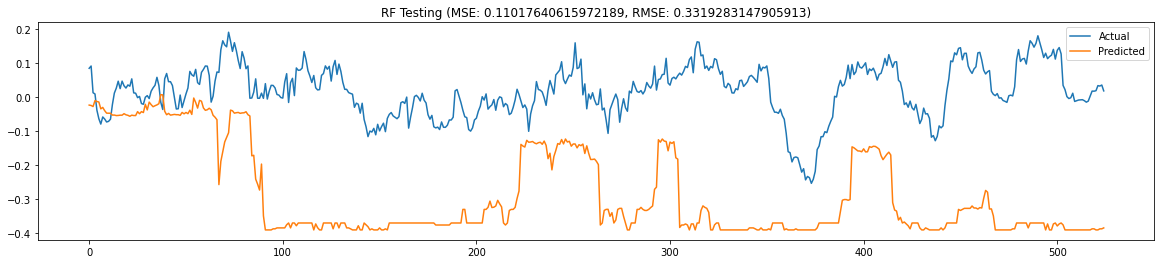

In [45]:
plot_results(actual_yrf, inv_yrf,'RF Testing',range(len(testMinmax_y)), 20)

#### LR

In [47]:
linreg = LinearRegression().fit(trainMinmax_x, trainMinmax_y)
#print(linreg.score(trainMinmax_x, trainMinmax_y))
predictions = linreg.predict(testMinmax_x)

print(linreg.score(testMinmax_x, testMinmax_y))

-0.6495260319016656


In [48]:
matrix = concatenate((testMinmax_x,predictions.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
inv_ylr = matrix_min_max_invert[:,-1]

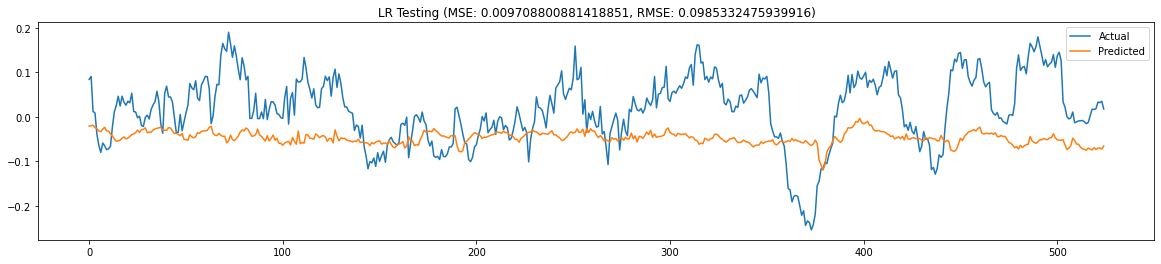

In [49]:
plot_results(actual_yrf, inv_ylr,'LR Testing',range(len(testMinmax_y)), 20)

#### LSTM:

##### Model train

In [99]:
neurons= [100, 100, 100, 100]
epochs=100
batch_size=64
decay_lr= True
lr= 0.0001

historym, model = experiments_lstm(STEP_OUT, SEQ_LEN, X_train, Y_train, X_val, Y_val, neurons, batch_size, epochs, decay_lr, lr)

[0.5488135  0.71518937 0.60276338 0.54488318]
Using decay lr


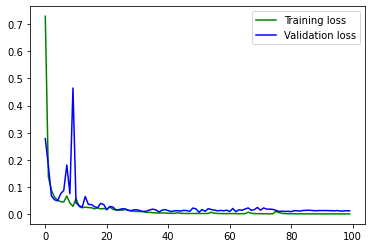

In [89]:
plt.plot(historym.history['loss'],'g',label="Training loss")
plt.plot(historym.history['val_loss'], 'b',label="Validation loss")
plt.legend()
plt.show()

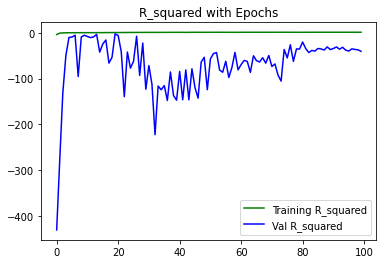

In [100]:
plt.plot(historym.history['r_squared_metric'],'g',label="Training R_squared")
plt.plot(historym.history['val_r_squared_metric'], 'b',label="Val R_squared")
plt.title('R_squared with Epochs')
plt.legend()
plt.show()

In [101]:
print('Train: ', model.evaluate(X_train, Y_train, verbose=0)[2])
print('Val: ', model.evaluate(X_val, Y_val, verbose=0, batch_size=X_val.shape[0])[2])
print('Test: ', model.evaluate(X_test, Y_test, verbose=0, batch_size=X_test.shape[0])[2])

Train:  0.6237714886665344
Val:  -0.21856844425201416
Test:  0.33945995569229126


In [102]:
# validation metrics 
lstmValPred = model.predict(X_val)
actual_valy= invert_scaling(valMinmax_x, Y_val, SEQ_LEN)
inv_valy= invert_scaling(valMinmax_x, lstmValPred, SEQ_LEN)

#out of sample metrics
lstmOutSamplePred = model.predict(X_test)
actual_y= invert_scaling(testMinmax_x, Y_test, SEQ_LEN)
inv_y= invert_scaling(testMinmax_x, lstmOutSamplePred, SEQ_LEN)

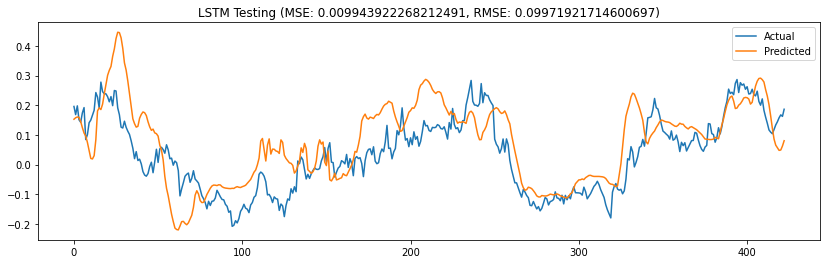

In [103]:
#plot_results(actual_valy ,inv_valy  ,'LSTM Validation',range(len(actual_valy)))
plot_results(actual_y ,inv_y  ,'LSTM Testing',range(len(actual_y)), 14)

In [104]:
test_signal= 1*(actual_y>0)
pred_signal= 1*(inv_y>0)

right= sum(test_signal==pred_signal)
wrong= len(actual_y)-right

print('Right: ', right, 'Wrong: ', wrong)

Right:  363 Wrong:  60


### 3 Months return:

In [64]:
FUTURE_PERIOD_PREDICT= 70
SEQ_LEN= 100
STEP_OUT=1 

In [65]:
# Prepare data
df1= df.copy()

df1['Close_shift'] = df1['Close'].shift(-FUTURE_PERIOD_PREDICT)
df1['Return1']= df1['Close_shift']/ df1['Close']
df1['Return2']= df1['Return1']-1
df1['Return']= df1['Return2'].shift(-1)

df1= df1.dropna(axis=0)
df1= df1[['Open','High', 'Low',	'Volume', 'Close', 'Return']]

df1['H-L'] = df1['High'] - df1['Low']
df1['O-C'] = df1['Close'] - df1['Open']
df1['3day_MA'] = df1['Close'].shift(1).rolling(window = 3).mean()
df1['10day_MA'] = df1['Close'].shift(1).rolling(window = 10).mean()
df1['30day_MA'] = df1['Close'].shift(1).rolling(window = 30).mean()
df1['Std_dev']= df1['Close'].rolling(5).std()
df1['RSI'] = RSI(df1) #talib.RSI(df1['Close'].values, timeperiod = 9)
df1['wr_14'] = get_wr(df1['High'], df1['Low'], df1['Close'], 14)

df1= df1.dropna(axis=0)
new_cols=['H-L','O-C','3day_MA','10day_MA','30day_MA',	'Std_dev','RSI','wr_14', 'Return']

df1=df1[new_cols]

In [66]:
train, validation, test= split_test_train(df1)
train_scaled, val_scaled, test_scaled= scale(train, validation, test, min_max_scaler)
trainMinmax_x, trainMinmax_y= split_xy(train_scaled)
valMinmax_x, valMinmax_y= split_xy(val_scaled)
testMinmax_x, testMinmax_y= split_xy(test_scaled)

X_train, Y_train = split_sequences_new(train_scaled, SEQ_LEN, STEP_OUT)
X_val, Y_val = split_sequences_new(val_scaled, SEQ_LEN, STEP_OUT)
X_test, Y_test = split_sequences_new(test_scaled, SEQ_LEN, STEP_OUT)

X_train.shape

(6613, 100, 8)

#### RF:

In [67]:
regr = RandomForestRegressor(max_depth=10, min_samples_split=30, random_state=0)
regr.fit(trainMinmax_x, trainMinmax_y)
pred_rf= regr.predict(testMinmax_x)
compute_r_squared(testMinmax_y, pred_rf)

-13.080899776477041

In [68]:
matrix = concatenate((testMinmax_x,testMinmax_y.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
actual_yrf = matrix_min_max_invert[:,-1]


matrix = concatenate((testMinmax_x,pred_rf.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
inv_yrf = matrix_min_max_invert[:,-1]

In [70]:
print('RMSE: ',sqrt(mean_squared_error(actual_yrf, inv_yrf)))

RMSE:  0.4737217749588156


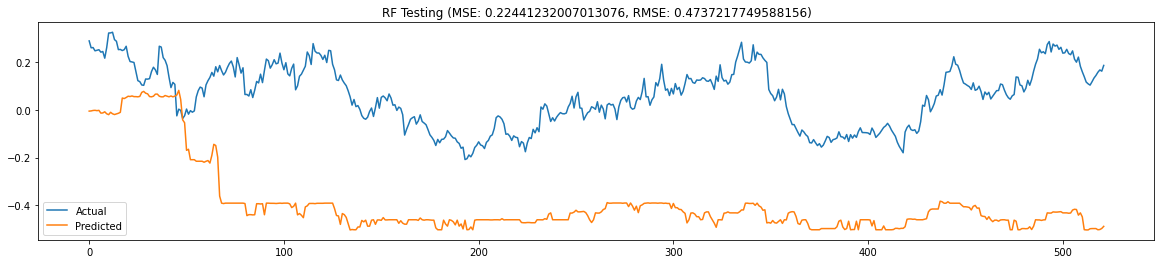

In [71]:
plot_results(actual_yrf, inv_yrf,'RF Testing',range(len(testMinmax_y)), 20)

#### LR

In [72]:
linreg = LinearRegression().fit(trainMinmax_x, trainMinmax_y)
predictions = linreg.predict(testMinmax_x)

print(linreg.score(testMinmax_x, testMinmax_y))

-2.222570010820599


In [73]:
matrix = concatenate((testMinmax_x,predictions.reshape(-1,1)), axis=1)
matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
inv_ylr = matrix_min_max_invert[:,-1]


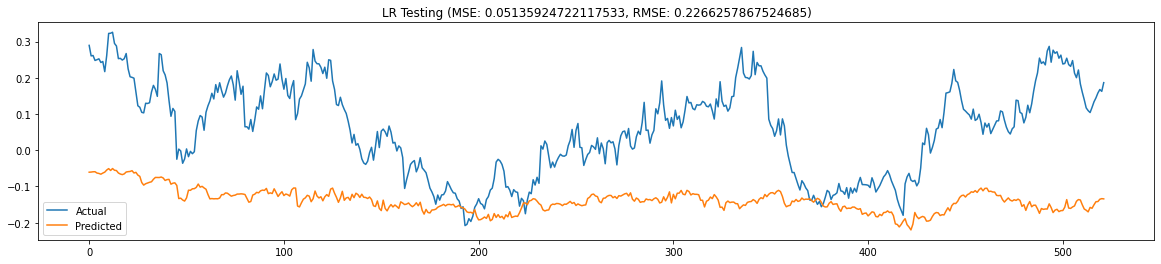

In [74]:
plot_results(actual_yrf, inv_ylr,'LR Testing',range(len(testMinmax_y)), 20)

#### LSTM:

In [75]:
neurons= [100, 100, 100, 100]
epochs=200
batch_size=64
decay_lr= True
lr= 0.01

history, modelq = experiments_lstm(STEP_OUT, SEQ_LEN, X_train, Y_train, X_val, Y_val, neurons, batch_size, epochs, decay_lr, lr)

[0.5488135  0.71518937 0.60276338 0.54488318]
Using decay lr


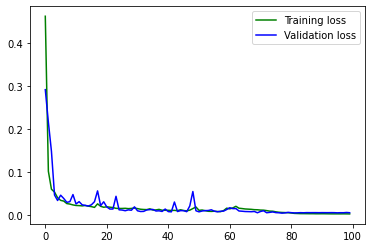

In [77]:
plt.plot(historym.history['loss'],'g',label="Training loss")
plt.plot(historym.history['val_loss'], 'b',label="Validation loss")
plt.legend()
plt.show()

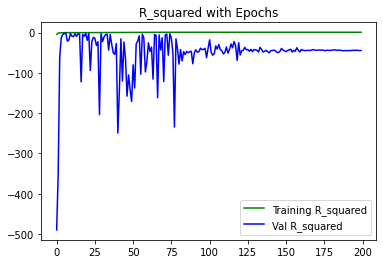

In [76]:
plt.plot(history.history['r_squared_metric'],'g',label="Training R_squared")
plt.plot(history.history['val_r_squared_metric'], 'b',label="Val R_squared")
plt.title('R_squared with Epochs')
plt.legend()
plt.show()

In [78]:
print('Train: ', modelq.evaluate(X_train, Y_train, verbose=0, batch_size=X_train.shape[0])[2])
print('Val: ', modelq.evaluate(X_val, Y_val, verbose=0, batch_size=X_val.shape[0])[2])
print('Test: ',modelq.evaluate(X_test, Y_test, verbose=0, batch_size=X_test.shape[0])[2])

Train:  0.9795685410499573
Val:  -0.13235008716583252
Test:  -2.0267181396484375


In [79]:
# validation metrics 
lstmValPred = modelq.predict(X_val)
actual_valy= invert_scaling(valMinmax_x, Y_val, SEQ_LEN)
inv_valy= invert_scaling(valMinmax_x, lstmValPred, SEQ_LEN)

#out of sample metrics
lstmOutSamplePred = modelq.predict(X_test)
actual_y= invert_scaling(testMinmax_x, Y_test, SEQ_LEN)
inv_y= invert_scaling(testMinmax_x, lstmOutSamplePred, SEQ_LEN)

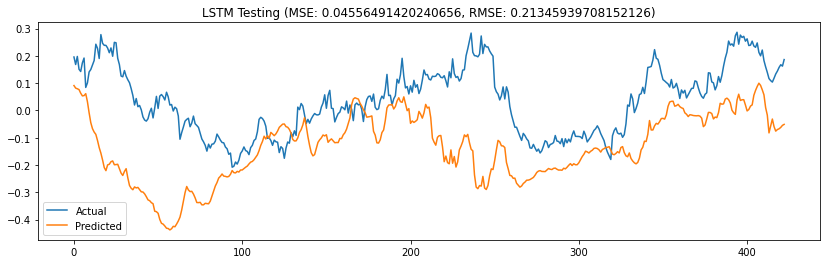

In [80]:
#plot_results(actual_valy ,inv_valy  ,'LSTM Validation',range(len(actual_valy)))
plot_results(actual_y ,inv_y  ,'LSTM Testing',range(len(actual_y)), 14)

In [81]:
test_signal= 1*(actual_y>0)
pred_signal= 1*(inv_y>0)

right= sum(test_signal==pred_signal)
wrong= len(actual_y)-right

print('Right: ', right, 'Wrong: ', wrong)

Right:  229 Wrong:  194


### Tuning LSTM model

In [ ]:
neurons_list= [[200, 100, 100, 100], [100, 100, 100, 100], [300, 200, 100, 100],[128, 128, 64, 64], [256, 128, 64, 64], [256, 128, 128, 64], [512, 256, 256, 128], [256, 256, 256, 128], [128, 128, 128, 64]]
batch_list= [32, 64, 100, 128]
#drop_list=[0, 0.5, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

opt_list= ['SGD', 'ADAM', 'RMSProp']

r_square_scorelist={}

In [ ]:
epochs=100
lr=0.01
decay_lr= True

In [ ]:
for neurons_l in neurons_list:
    for optname in opt_list:
        for batch in batch_list:
            print('Training for: {} neurons, opt= {}, batch= {}'.format(neurons_l, optname, batch) )
            model= experiments_lstm(STEP_OUT, SEQ_LEN, X_train, Y_train, X_val, Y_val, neurons_l, batch, epochs, decay_lr, lr, optname)
            train_score= model.evaluate(X_train, Y_train, verbose=0, batch_size=X_train.shape[0])[2]
            val_score= model.evaluate(X_val, Y_val, verbose=0, batch_size=X_val.shape[0])[2]
            test_score= model.evaluate(X_test, Y_test, verbose=0, batch_size=X_test.shape[0])[2]
            keystr= str(neurons_l)+str(optname)+str(batch)
            r_square_scorelist[keystr]= {'train': train_score, 'val': val_score, 'test': test_score}
            #print('train: {} val: {} test: {} '.format(train_score,val_score, test_score))


In [ ]:
filenm= '/content/sample_data/r_score.txt'

In [ ]:
import json

In [ ]:
with open(filenm, 'w') as convert_file:
     convert_file.write(json.dumps(r_square_scorelist))